In [1]:
import sys
sys.path.append('third_party/Matcha-TTS')
from cosyvoice.cli.cosyvoice import CosyVoice, CosyVoice2
from cosyvoice.utils.file_utils import load_wav
import torchaudio
import argparse
import numpy as np
import torch
import IPython.display as ipd
from tqdm import tqdm
from typing import Generator
import matplotlib.pyplot as plt

2025-03-02 23:50:40,368 - modelscope - INFO - PyTorch version 2.0.1+cu118 Found.
2025-03-02 23:50:40,384 - modelscope - INFO - Loading ast index from /home/renyi/.cache/modelscope/ast_indexer
2025-03-02 23:50:40,578 - modelscope - INFO - Loading done! Current index file version is 1.15.0, with md5 714a31fcdf1786986dd111152032b1a0 and a total number of 980 components indexed


failed to import ttsfrd, use WeTextProcessing instead


In [2]:
cosyvoice = CosyVoice2('pretrained_models/CosyVoice2-0.5B', load_jit=False, load_trt=False, fp16=False)

/home/renyi/anaconda3/envs/cosyvoice2/lib/python3.8/site-packages/diffusers/models/lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
2025-03-02 23:51:07,791 INFO input frame rate=25
/home/renyi/anaconda3/envs/cosyvoice2/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
2025-03-02 23:51:16,004 WETEXT INFO building fst for zh_normalizer ...
2025-03-02 23:51:16,004 INFO building fst for zh_normalizer ...
2025-03-02 23:51:34,172 WETEXT INFO done
2025-03-02 23:51:34,172 INFO done
2025-03-02 23:51:34,174 WETEXT INFO fst path: /home/renyi/anaconda3/envs/co

In [14]:
def get_feat_from_audio(wav_path: str, prompt_text: str, tts_text: str):
    prompt_speech_16k = load_wav(wav_path, 16000)
    prompt_text = cosyvoice.frontend.text_normalize(prompt_text, split=False, text_frontend=True)
    tts_text = cosyvoice.frontend.text_normalize(tts_text, split=False, text_frontend=True)
    model_input = cosyvoice.frontend.frontend_zero_shot(tts_text, prompt_text, prompt_speech_16k, cosyvoice.sample_rate)
    return model_input

In [77]:
wav_path1 = "audios/5338_2.wav"
prompt_text1 = "You are not like my people, the Pinkies, and there is no place for you in our country."
wav_path2 = "audios/5338_2_K.wav"
prompt_text2 = "You are not like my people, the Pinkies, and there is no place for you in our country."
tts_text = "The quick brown fox jumps over the lazy dog."

In [78]:
model_input = get_feat_from_audio(wav_path1, prompt_text1, tts_text)
model_input_ref = get_feat_from_audio(wav_path2, prompt_text2, tts_text)

In [79]:
token1 = model_input['llm_prompt_speech_token']
token2 = model_input_ref['llm_prompt_speech_token']
# draw the 2 token

token1.size(), token2.size()

(torch.Size([1, 103]), torch.Size([1, 103]))

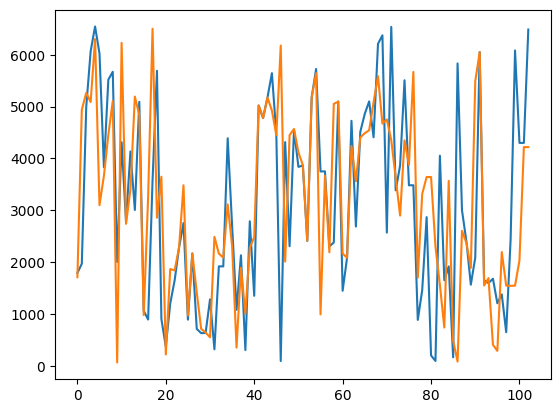

In [80]:
plt.plot(token1[0].cpu().numpy())
plt.plot(token2[0].cpu().numpy())


In [3]:
import s3tokenizer
tokenizer = s3tokenizer.load_model("speech_tokenizer_v2_25hz").cuda() 
tokenizer.train()

S3TokenizerV2(
  (encoder): AudioEncoderV2(
    (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-5): 6 x ResidualAttentionBlock(
        (attn): FSMNMultiHeadAttention(
          (query): Linear(in_features=1280, out_features=1280, bias=True)
          (key): Linear(in_features=1280, out_features=1280, bias=False)
          (value): Linear(in_features=1280, out_features=1280, bias=True)
          (out): Linear(in_features=1280, out_features=1280, bias=True)
          (fsmn_block): Conv1d(1280, 1280, kernel_size=(31,), stride=(1,), groups=1280, bias=False)
          (pad_fn): ConstantPad1d(padding=(15, 15), value=0.0)
        )
        (attn_ln): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Line

In [41]:
def get_speech_token(speech_16k):
    s3tokenizer.padding([s3tokenizer.log_mel_spectrogram(speech_16k)])
    mels , mels_lens = s3tokenizer.padding([s3tokenizer.log_mel_spectrogram(speech_16k)])
    return tokenizer.quantize(mels.cuda(), mels_lens.cuda())

In [81]:
def optimize_input_representation(path, ref_path, strength = 0.01, num_steps=500, lr=0.001,
output=True):
    
    x = s3tokenizer.load_audio(path)
    optimizer = torch.optim.AdamW([x], lr=lr)
    loss_history = []
    original_x = x.clone().detach()
    
    ref_x = s3tokenizer.load_audio(ref_path)
    mels , mels_lens = s3tokenizer.padding([s3tokenizer.log_mel_spectrogram(ref_x)])
    mel = mels.cuda()
    hidden_ref, _ = tokenizer.encoder(mel, mels_lens.to(mel.device))
    
    max_amp = torch.max(torch.abs(original_x))
    eps = strength * max_amp
    
    x.requires_grad = True
    
    for step in range(num_steps):
        optimizer.zero_grad()
            
        mels , mels_lens = s3tokenizer.padding([s3tokenizer.log_mel_spectrogram(x)])
        mel = mels.cuda()
        hidden, _ = tokenizer.encoder(mel, mels_lens.to(mel.device))
        
        loss = torch.nn.functional.mse_loss(hidden, hidden_ref)

        
        loss_history.append(loss.item())

        loss.backward(retain_graph=True)

        optimizer.step()
        
        x.data = torch.clamp(x, original_x - eps, original_x + eps)

        if step % 5 == 0 and output:
            print(f"Step {step}, Loss: {loss.item()}")


    return x, loss_history



Step 0, Loss: 0.10150638967752457
Step 5, Loss: 0.059660736471414566
Step 10, Loss: 0.04768927022814751
Step 15, Loss: 0.040809161961078644
Step 20, Loss: 0.03636355698108673
Step 25, Loss: 0.033188194036483765
Step 30, Loss: 0.03072044998407364
Step 35, Loss: 0.02873164415359497
Step 40, Loss: 0.027025725692510605
Step 45, Loss: 0.025733178481459618
Step 50, Loss: 0.024605335667729378
Step 55, Loss: 0.023658134043216705
Step 60, Loss: 0.022780150175094604
Step 65, Loss: 0.02204662375152111
Step 70, Loss: 0.021368030458688736
Step 75, Loss: 0.0208149291574955
Step 80, Loss: 0.020310906693339348
Step 85, Loss: 0.01989356055855751
Step 90, Loss: 0.01947038806974888
Step 95, Loss: 0.01910494454205036
Step 100, Loss: 0.018804561346769333
Step 105, Loss: 0.018518412485718727
Step 110, Loss: 0.018231825903058052
Step 115, Loss: 0.018102098256349564
Step 120, Loss: 0.017928991466760635
Step 125, Loss: 0.01762949861586094
Step 130, Loss: 0.017460139468312263
Step 135, Loss: 0.01726615428924560

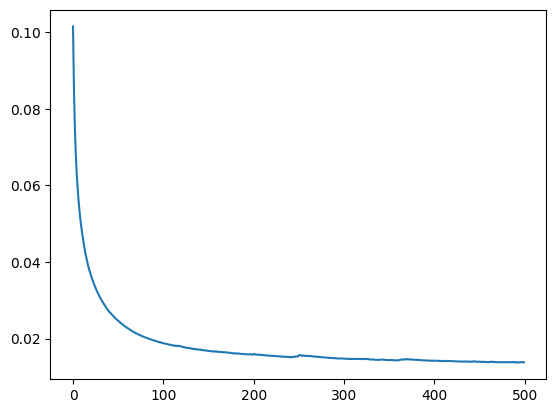

In [82]:
x_adv,loss = optimize_input_representation(wav_path1, wav_path2, strength=0.025)
plt.plot(loss)

In [83]:
x_np = x_adv.cpu().detach().numpy()
torchaudio.save("audios/adv_025%.wav", x_adv.unsqueeze(0), 16000)
ipd.Audio(x_np, rate=16000)

#store the adversarial example


In [53]:
token_adv, token_adv_len = get_speech_token(x_adv)

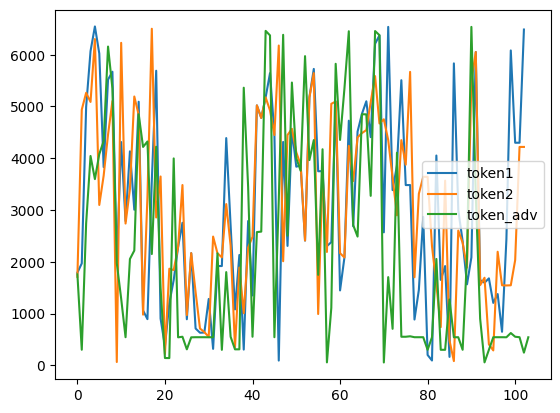

In [60]:
# plot the token in the same plot as line
plt.plot(token1[0].cpu().numpy(), label='token1')
plt.plot(token2[0].cpu().numpy(), label='token2')
plt.plot(token_adv[0].cpu().numpy(), label='token_adv')
plt.legend()

In [7]:
def perturb_token(token: torch.Tensor, strength: float):
    min_val = torch.min(token)
    max_val = torch.max(token)
    noise = torch.randn_like(token, dtype=torch.float) * (token.abs().to(torch.float) * strength)
    perturbed = token.to(torch.float) + noise
    perturbed = torch.clamp(perturbed, min=min_val, max=max_val)
    if not torch.is_floating_point(token):
        perturbed = perturbed.round()
    return perturbed.to(token.dtype)

token_adv = perturb_token(token1, 0.05)

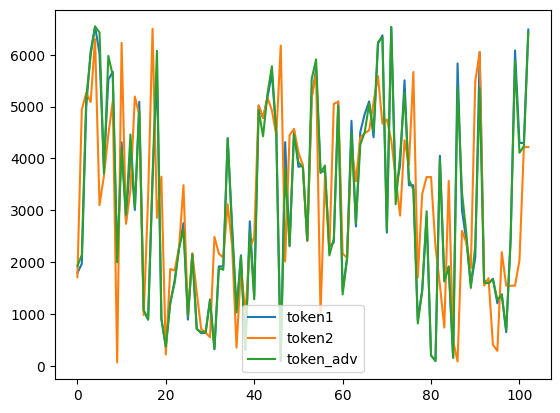

In [8]:
# plot the token in the same plot as line
plt.plot(token1[0].cpu().numpy(), label='token1')
plt.plot(token2[0].cpu().numpy(), label='token2')
plt.plot(token_adv[0].cpu().numpy(), label='token_adv')
plt.legend()

In [55]:
tts_speech_tokens = []
for token in cosyvoice.model.llm.inference(
    text=model_input['text'].to(cosyvoice.model.device),
    text_len=torch.tensor([model_input['text'].shape[1]], dtype=torch.int32).to(cosyvoice.model.device),
    prompt_text=model_input['prompt_text'].to(cosyvoice.model.device),
    prompt_text_len=torch.tensor([model_input['prompt_text'].shape[1]], dtype=torch.int32).to(cosyvoice.model.device),
    prompt_speech_token=token_adv.to(cosyvoice.model.device),
    prompt_speech_token_len=torch.tensor([token_adv.shape[1]], dtype=torch.int32).to(cosyvoice.model.device),
    embedding=model_input['llm_embedding'].to(cosyvoice.model.device)
):
    tts_speech_tokens.append(token)

tts_speech_token = torch.tensor(tts_speech_tokens).unsqueeze(0)


In [56]:
tts_mel, _ = cosyvoice.model.flow.inference(
        token=tts_speech_token.to(cosyvoice.model.device),
        token_len=torch.tensor([tts_speech_token.shape[1]], dtype=torch.int32).to(cosyvoice.model.device),
        prompt_token=token_adv.to(cosyvoice.model.device),
        prompt_token_len=torch.tensor([token_adv.shape[1]], dtype=torch.int32).to(cosyvoice.model.device),
        prompt_feat=model_input['prompt_speech_feat'].to(cosyvoice.model.device),
        prompt_feat_len=torch.tensor([model_input['prompt_speech_feat'].shape[1]], dtype=torch.int32).to(cosyvoice.model.device),
        embedding=model_input['flow_embedding'].to(cosyvoice.model.device),
        finalize=True
    )

tts_speech, _ = cosyvoice.model.hift.inference(speech_feat=tts_mel, cache_source=torch.zeros(1, 1, 0))
ipd.Audio(tts_speech.cpu(), rate=cosyvoice.sample_rate)


In [11]:
model_output = next(cosyvoice.model.tts(**model_input, stream=False, speed=1.0))
torchaudio.save("audios/syn.wav", model_output['tts_speech'], cosyvoice.sample_rate)

In [9]:
audio_prompt , sr = torchaudio.load(wav_path1)
ipd.Audio(audio_prompt[0].cpu(), rate=sr)

In [31]:
audio_prompt_16k = torchaudio.transforms.Resample(sr, 16000)(audio_prompt)

speech_token ,len= cosyvoice.frontend._extract_speech_token(audio_prompt_16k)
assert torch.equal(speech_token[:, :-1], model_input['llm_prompt_speech_token'])

torch.Size([0, 104])

In [25]:
model_input['llm_prompt_speech_token'].size()

torch.Size([1, 103])